In [1]:
import torch
from torch import nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint

from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import json

from sentence_transformers import CrossEncoder, InputExample, losses
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator

In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
ds = load_dataset('squad_v2')

Found cached dataset squad_v2 (/home/jupyter/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
ds_ = ds['train'].train_test_split(test_size=0.1, seed=42)
train_origin = ds_['train']
val_origin = ds_['test']
test_origin = ds['validation']

Loading cached split indices for dataset at /home/jupyter/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-8392fe7aa8289e19.arrow and /home/jupyter/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-10963ca112a1f503.arrow


In [7]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [8]:
# mapper functions:
# 1. split context into sentences
# 2. concat k consecutive sentences to form a chunk for cross-encoder, example: [sent1, sent2, sent3, sent4] -> [[sent1, sent2], [sent2, sent3], [sent3, sent4]]
# mark the label of each chunk as 1 if any sentence in the chunk contains the answer, otherwise 0

# empty_chunk_list, answer_answer_list = [], []
def mapper(examples, k_sentences_for_one_chunk, stride):
    batch_sentences, batch_questions, batch_chunk_labels, batch_chunks, batch_num_chunk_tokens, batch_num_context_tokens = [], [], [], [], [], []
    for i in range(len(examples['context'])):
        sentences = sent_tokenize(examples['context'][i])
        chunks_list = []
        if len(sentences) < k_sentences_for_one_chunk:
            chunks_list.append(sentences)
        else:
            for j in range(0, len(sentences) - k_sentences_for_one_chunk + 2, stride):
                chunks_list.append(sentences[j:j+k_sentences_for_one_chunk])
        chunks = [' '.join(chunk) for chunk in chunks_list]
        answer_list = examples['answers'][i]['text']
        if len(answer_list) == 0:
            chunk_labels = [0 for chunk in chunks]
        else:
            answer = answer_list[0]
            chunk_labels = [1 if answer in chunk else 0 for chunk in chunks]
        

        batch_sentences.append(sentences)
        batch_questions.append(examples['question'][i])
        batch_chunk_labels.append(chunk_labels)
        batch_chunks.append(chunks)
        batch_num_chunk_tokens.append([len(input_ids) for input_ids in tokenizer(chunks)['input_ids']])
        batch_num_context_tokens.append(len(tokenizer(examples['context'][i])['input_ids']))

    return {
        'chunk_labels': batch_chunk_labels,
        'chunks': batch_chunks,
        'question': batch_questions,
        'sentence': batch_sentences,
        'num_chunks': [len(chunks) for chunks in batch_chunks],
        'num_sentences': [len(sentences) for sentences in batch_sentences],
        'num_chunk_tokens': batch_num_chunk_tokens,
        'num_context_tokens': batch_num_context_tokens
    }

In [9]:
train_dataset_for_ce = train_origin.map(mapper, batched=True, fn_kwargs={'k_sentences_for_one_chunk': 3, 'stride':2})
val_dataset_for_ce = val_origin.map(mapper, batched=True, fn_kwargs={'k_sentences_for_one_chunk': 3, 'stride': 2})
test_dataset_for_ce = test_origin.map(mapper, batched=True, fn_kwargs={'k_sentences_for_one_chunk': 3, 'stride': 2})

Map:   0%|          | 0/117287 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Number of sentences in each context')

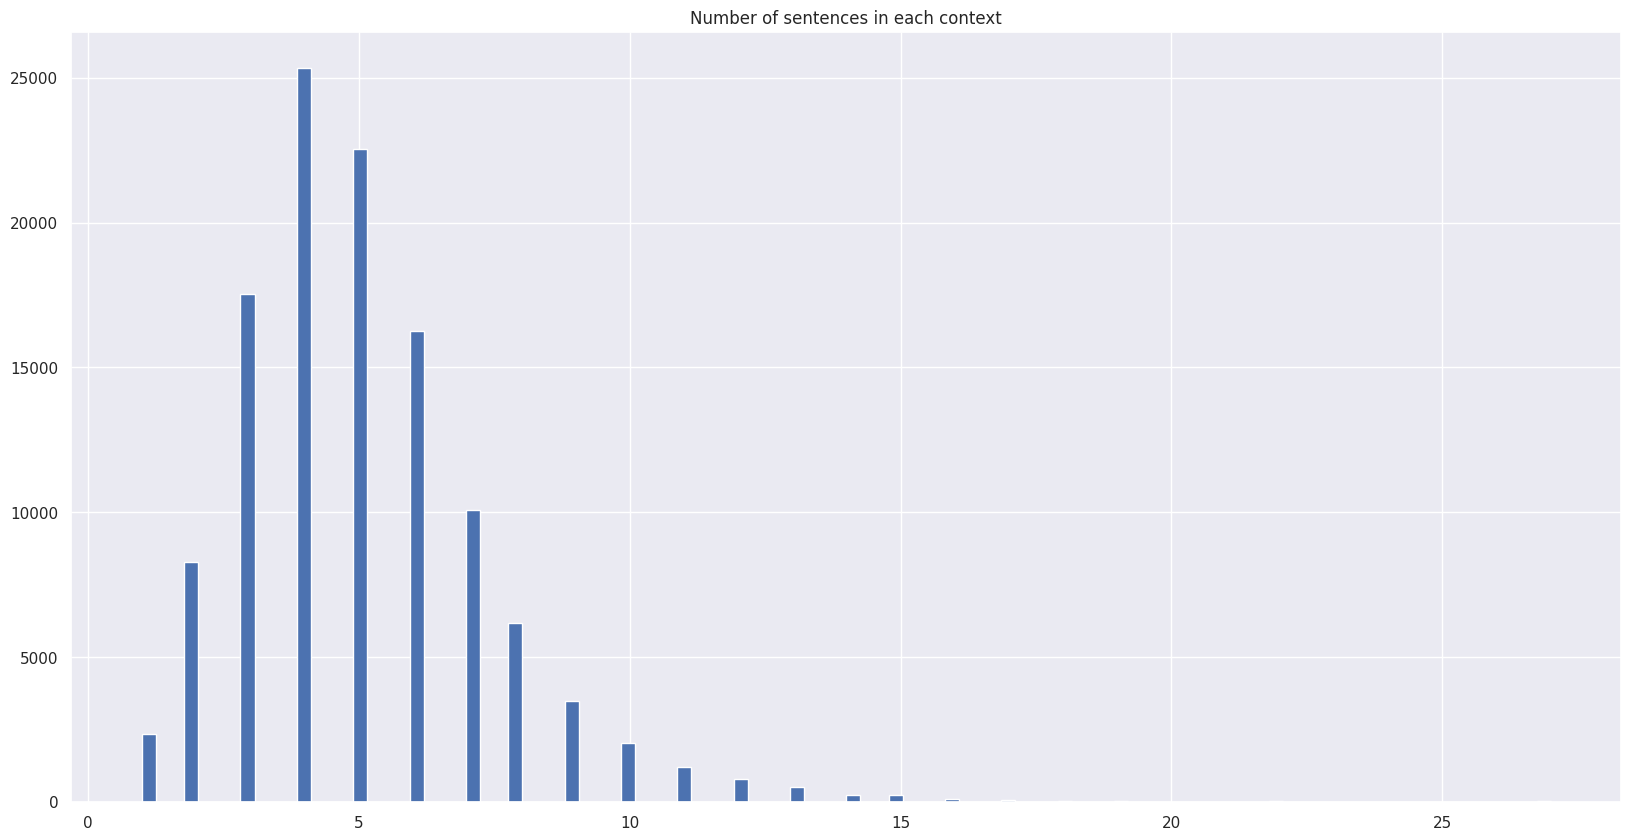

In [10]:
df = train_dataset_for_ce.to_pandas()
plt.figure(figsize=(20,10))
df['num_sentences'].hist(bins=100)
plt.title('Number of sentences in each context')

Text(0.5, 1.0, 'Number of chunks per example')

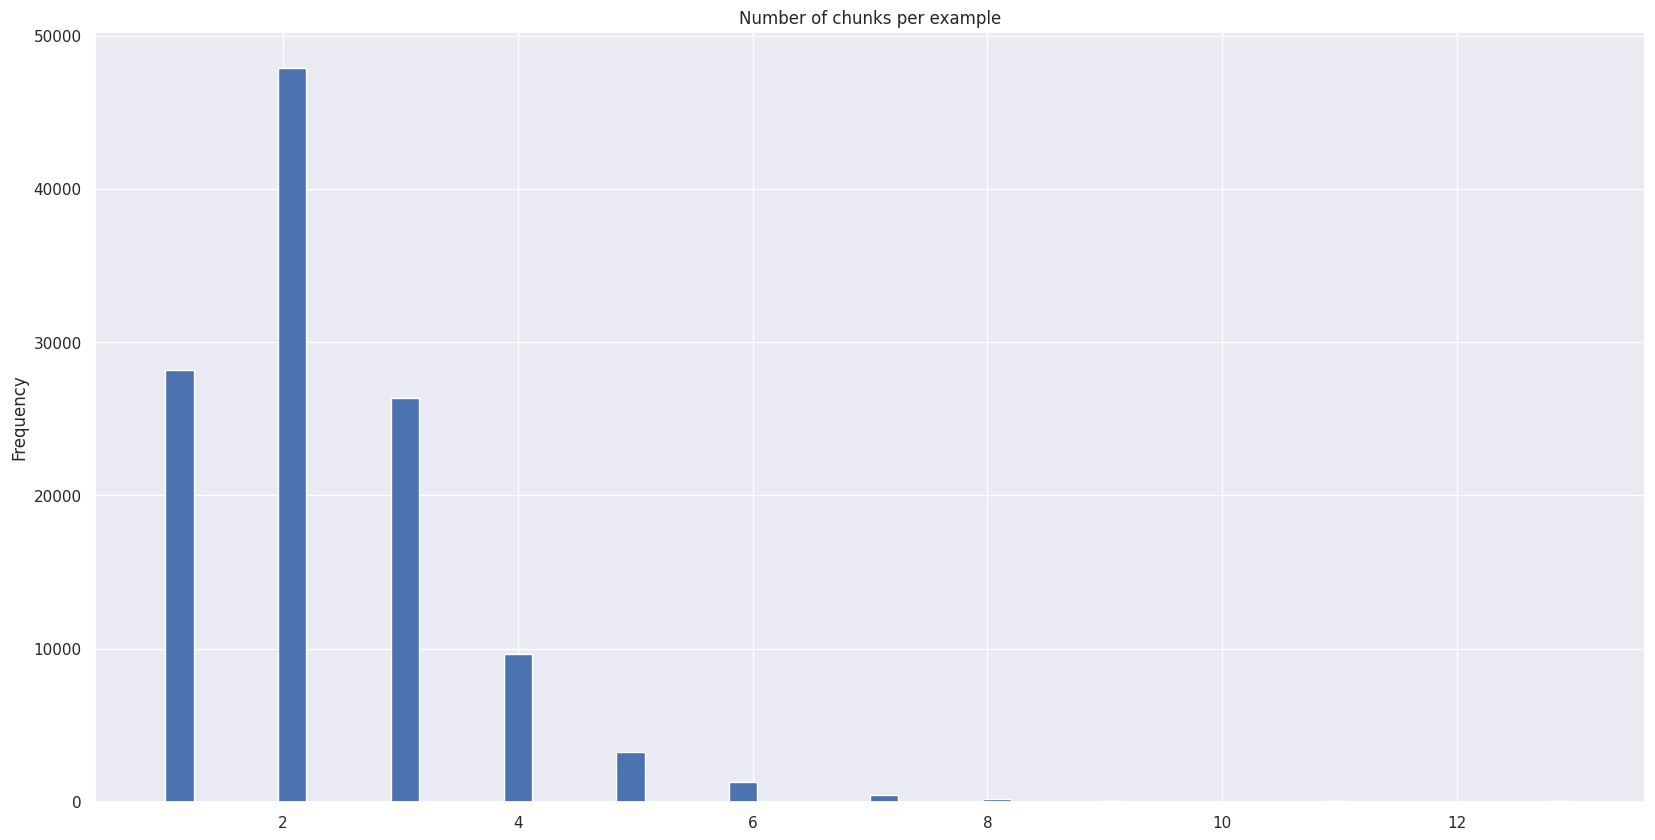

In [11]:
plt.figure(figsize=(20,10))
df['num_chunks'].plot.hist(bins=50)
plt.title('Number of chunks per example')

Text(0.5, 1.0, 'Number of tokens per chunk')

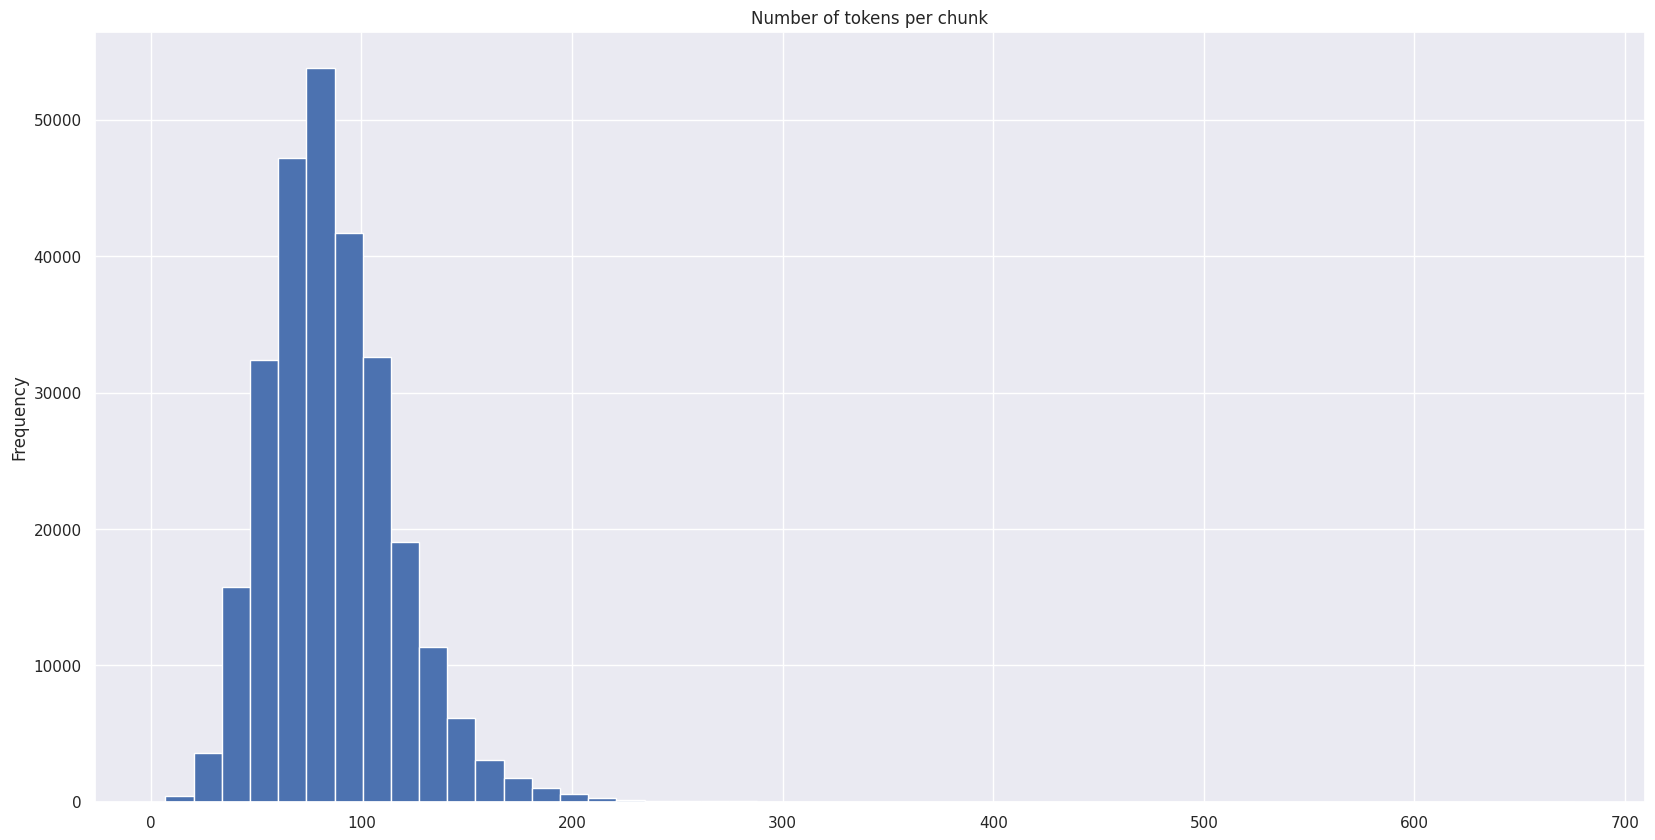

In [12]:
plt.figure(figsize=(20,10))
df['num_chunk_tokens'].explode().plot.hist(bins=50)
plt.title('Number of tokens per chunk')

In [13]:
df['num_chunk_tokens'].explode().astype(float).describe()

count    271153.000000
mean         86.426921
std          30.883583
min           7.000000
25%          65.000000
50%          83.000000
75%         104.000000
max         676.000000
Name: num_chunk_tokens, dtype: float64

In [14]:
train_examples = []
for i in tqdm(range(len(train_dataset_for_ce))):
    for j in range(len(train_dataset_for_ce[i]['chunks'])):
        train_examples.append(InputExample(texts=[train_dataset_for_ce[i]['question'], train_dataset_for_ce[i]['chunks'][j]], label=train_dataset_for_ce[i]['chunk_labels'][j]))

val_examples = []
for i in tqdm(range(len(val_dataset_for_ce))):
    for j in range(len(val_dataset_for_ce[i]['chunks'])):
        val_examples.append(InputExample(texts=[val_dataset_for_ce[i]['question'], val_dataset_for_ce[i]['chunks'][j]], label=val_dataset_for_ce[i]['chunk_labels'][j]))


  0%|          | 0/117287 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

In [15]:
len(train_examples)

271153

In [16]:
cross_encoder = CrossEncoder('roberta-base', num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [17]:
cross_encoder_model_path = './checkpoints/ce_model_10_6_2023_roberta_squad2'

In [18]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(val_examples, name='val')
warmup_steps = int(len(train_dataloader) * 0.1) # 10% of train data for warm-up

cross_encoder.fit(
    train_dataloader=train_dataloader, 
    evaluator=evaluator, 
    epochs=2, 
    warmup_steps=warmup_steps, 
    evaluation_steps=2000,
    output_path=cross_encoder_model_path
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8474 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8474 [00:00<?, ?it/s]

In [19]:
cross_encoder = CrossEncoder(cross_encoder_model_path)

In [20]:
def build_dataset_for_reader(examples, k_top_chunks=3):
    # 1) calculate score for each chunk in one example
    # 2) select top k chunks with highest score
    # 3) concat k chunks to form a context for reader in order of their appearance in the original context
    batch_combined_context, batch_scores, batch_answers = [], [], []
    for i in (range(len(examples['question']))):
        question = examples['question'][i]
        chunks = examples['chunks'][i]
        scores = cross_encoder.predict([[question, chunk] for chunk in chunks])
        score_1 = np.exp(scores[:, 1]) / np.sum(np.exp(scores), axis=1)
        top_k_indices = np.argsort(score_1)[-k_top_chunks:]
        top_k_chunks = []        
        for j in range(len(chunks)):
            if j in top_k_indices:
                top_k_chunks.append(chunks[j])
        candidate_contexts = []
        for chunk in top_k_chunks:
            chunk_sentences = sent_tokenize(chunk)
            for sentence in chunk_sentences:
                if sentence not in candidate_contexts:
                    candidate_contexts.append(sentence)
        combined_context = ' '.join(candidate_contexts)
        answer_texts = [answer for answer in examples['answers'][i]['text'] if answer in combined_context]
        answer_starts = [combined_context.index(answer) for answer in answer_texts]

        batch_combined_context.append(combined_context)
        batch_scores.append([score_1[i] for i in range(len(chunks)) if i in top_k_indices])
        batch_answers.append({
            'text': answer_texts,
            'answer_start': answer_starts
        })

    return {
        'id': examples['id'],
        'question': examples['question'],
        'title': examples['title'],
        'context': batch_combined_context,
        'scores': batch_scores,
        'answers': batch_answers,
        'old_answers': examples['answers']
    }


In [21]:
train_dataset_for_reader = train_dataset_for_ce.map(build_dataset_for_reader, batched=True, fn_kwargs={'k_top_chunks': 3}, remove_columns=train_dataset_for_ce.column_names)
val_dataset_for_reader = val_dataset_for_ce.map(build_dataset_for_reader, batched=True, fn_kwargs={'k_top_chunks': 3}, remove_columns=val_dataset_for_ce.column_names)        
test_dataset_for_reader = test_dataset_for_ce.map(build_dataset_for_reader, batched=True, fn_kwargs={'k_top_chunks': 3}, remove_columns=test_dataset_for_ce.column_names)        

Map:   0%|          | 0/117287 [00:00<?, ? examples/s]

Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [22]:
train_dataset_for_reader.save_to_disk('./data/train_dataset_for_reader_squad_roberta')
val_dataset_for_reader.save_to_disk('./data/val_dataset_for_reader_squad_roberta')
test_dataset_for_reader.save_to_disk('./data/test_dataset_for_reader_squad_roberta')

Saving the dataset (0/1 shards):   0%|          | 0/117287 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13032 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11873 [00:00<?, ? examples/s]

In [23]:
train_dataset_for_reader = Dataset.load_from_disk('./data/train_dataset_for_reader_squad_roberta')
val_dataset_for_reader = Dataset.load_from_disk('./data/val_dataset_for_reader_squad_roberta')
test_dataset_for_reader = Dataset.load_from_disk('./data/test_dataset_for_reader_squad_roberta')

In [24]:
count = 0
def preprocess_training_examples(examples):
    global count
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        if (len(answer['answer_start'])==0):
            count+=1
            start_positions.append(0)
            end_positions.append(0)
            continue
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    example_ids = []
    for i in range(len(inputs["input_ids"])):
        example_ids.append(examples["id"][i])
        sequence_ids = inputs.sequence_ids(i)
        inputs["offset_mapping"][i] = [o if sequence_ids[k] == 1 else None \
          for k, o in enumerate(inputs["offset_mapping"][i])]

    inputs["example_id"] = example_ids
    return inputs

In [25]:
train_dataset = train_dataset_for_reader.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_dataset_for_reader.column_names,
)
val_dataset = val_dataset_for_reader.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=val_dataset_for_reader.column_names,
)
test_dataset = test_dataset_for_reader.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=test_dataset_for_reader.column_names,
)

Map:   0%|          | 0/117287 [00:00<?, ? examples/s]

Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [26]:
val_dataset_test = val_dataset_for_reader.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_dataset_for_reader.column_names,
)

Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

In [27]:
i = 10
print(train_origin[i])
print(train_dataset[i]['start_positions'])

{'id': '5ad255afd7d075001a428d49', 'title': 'Emotion', 'context': 'Emotions can motivate social interactions and relationships and therefore are directly related with basic physiology, particularly with the stress systems. This is important because emotions are related to the anti-stress complex, with an oxytocin-attachment system, which plays a major role in bonding. Emotional phenotype temperaments affect social connectedness and fitness in complex social systems (Kurt Kortschal 2013). These characteristics are shared with other species and taxa and are due to the effects of genes and their continuous transmission. Information that is encoded in the DNA sequences provides the blueprint for assembling proteins that make up our cells. Zygotes require genetic information from their parental germ cells, and at every speciation event, heritable traits that have enabled its ancestor to survive and reproduce successfully are passed down along with new traits that could be potentially benefi

In [28]:
class CustomModelForQuestionAnswering(nn.Module):
    def __init__(self, model_checkpoint):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(self.model.config.hidden_size, 2)
        self.W1 = nn.Linear(self.model.config.hidden_size, 1)
        self.W2 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_token = last_hidden_state[:, 0, :]

        answerable_logits = self.W1(torch.tanh(self.W2(cls_token)))
        start_logits, end_logits = self.qa_outputs(last_hidden_state).split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        
        # loss = lost_answerable + loss_start + loss_end
        loss, loss_answerable, loss_start, loss_end = None, None, None, None
        if start_positions is not None and end_positions is not None:
            answerables = ((start_positions != 0) & (end_positions != 0)).float().unsqueeze(-1)
            loss_answerable = F.binary_cross_entropy_with_logits(answerable_logits, answerables)
            loss_start = F.cross_entropy(start_logits, start_positions)
            loss_end = F.cross_entropy(end_logits, end_positions)
            loss = loss_answerable + loss_start + loss_end 

        return {
            'loss': loss,
            'answerable_logits': answerable_logits.squeeze(-1),
            'start_logits': start_logits,
            'end_logits': end_logits,
            'loss_answerable': loss_answerable,
            'loss_start': loss_start,
            'loss_end': loss_end
        }

In [29]:
model_checkpoint = 'roberta-base'
model = CustomModelForQuestionAnswering(model_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
def train(model, train_dataset, val_dataset, epochs=2, batch_size=24, lr=3e-5, train_eval_steps=1000, test_eval_steps=1000, accumulate_grad_steps=3, save_steps=2500):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    train_dataset.set_format(type='torch')
    val_dataset.set_format(type='torch')

    step = 0
    for epoch in tqdm(range(epochs)):
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        model.train()
        train_loss, train_loss_answerable, train_loss_start, train_loss_end = [], [], [], []
        for batch in tqdm(train_dataloader):
            step += 1

            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)

            loss = outputs['loss']
            loss.backward()

            train_loss.append(loss.item())
            train_loss_answerable.append(outputs['loss_answerable'].item())
            train_loss_start.append(outputs['loss_start'].item())
            train_loss_end.append(outputs['loss_end'].item())
            
            if step % accumulate_grad_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            if step % train_eval_steps == 0:
                print(f"Epoch {epoch+1}/{epochs} | Step {step} | Train loss: {np.mean(train_loss):.3f} | Train loss answerable: {np.mean(train_loss_answerable):.3f} | Train loss start: {np.mean(train_loss_start):.3f} | Train loss end: {np.mean(train_loss_end):.3f}")
                train_loss, train_loss_answerable, train_loss_start, train_loss_end = [], [], [], []

            if step % test_eval_steps == 0:
                model.eval()
                val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                val_loss, val_loss_answerable, val_loss_start, val_loss_end = [], [], [], []

                with torch.no_grad():
                    for batch in tqdm(val_dataloader):
                        inputs = {k: v.to(device) for k, v in batch.items()}
                        outputs = model(**inputs)
                        loss = outputs['loss']

                        val_loss.append(loss.item())
                        val_loss_answerable.append(outputs['loss_answerable'].item())
                        val_loss_start.append(outputs['loss_start'].item())
                        val_loss_end.append(outputs['loss_end'].item())
                        
                print(f"Epoch {epoch+1}/{epochs} | Step {step} | Val loss: {np.mean(val_loss):.3f} | Val loss answerable: {np.mean(val_loss_answerable):.3f} | Val loss start: {np.mean(val_loss_start):.3f} | Val loss end: {np.mean(val_loss_end):.3f}")
                model.train()

            if save_steps and step % save_steps == 0:
                torch.save(model, './checkpoint_reader_xlmr_squad2_app2/model_step_{}.pth'.format(step))

    train_dataset.reset_format()
    val_dataset.reset_format()
    torch.save(model, './checkpoint_reader_xlmr_squad2_app2/final.pth'.format(step))

In [31]:
train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=3,
    batch_size=32,
    lr=3e-5,
    train_eval_steps=1000,
    test_eval_steps=1000,
    accumulate_grad_steps=2,
    save_steps=2500
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3666 [00:00<?, ?it/s]

Epoch 1/3 | Step 1000 | Train loss: 3.838 | Train loss answerable: 0.517 | Train loss start: 1.691 | Train loss end: 1.630


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 1/3 | Step 1000 | Val loss: 2.684 | Val loss answerable: 0.414 | Val loss start: 1.167 | Val loss end: 1.102
Epoch 1/3 | Step 2000 | Train loss: 2.599 | Train loss answerable: 0.388 | Train loss start: 1.141 | Train loss end: 1.070


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 1/3 | Step 2000 | Val loss: 2.279 | Val loss answerable: 0.336 | Val loss start: 1.003 | Val loss end: 0.940
Epoch 1/3 | Step 3000 | Train loss: 2.334 | Train loss answerable: 0.335 | Train loss start: 1.035 | Train loss end: 0.964


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 1/3 | Step 3000 | Val loss: 2.173 | Val loss answerable: 0.308 | Val loss start: 0.968 | Val loss end: 0.896


  0%|          | 0/3666 [00:00<?, ?it/s]

Epoch 2/3 | Step 4000 | Train loss: 1.805 | Train loss answerable: 0.245 | Train loss start: 0.818 | Train loss end: 0.742


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 2/3 | Step 4000 | Val loss: 2.176 | Val loss answerable: 0.334 | Val loss start: 0.951 | Val loss end: 0.891
Epoch 2/3 | Step 5000 | Train loss: 1.813 | Train loss answerable: 0.238 | Train loss start: 0.820 | Train loss end: 0.755


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 2/3 | Step 6000 | Train loss: 1.771 | Train loss answerable: 0.234 | Train loss start: 0.796 | Train loss end: 0.741


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 2/3 | Step 6000 | Val loss: 1.909 | Val loss answerable: 0.255 | Val loss start: 0.863 | Val loss end: 0.791


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 3/3 | Step 10000 | Train loss: 1.390 | Train loss answerable: 0.162 | Train loss start: 0.641 | Train loss end: 0.587


  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 3/3 | Step 10000 | Val loss: 1.878 | Val loss answerable: 0.239 | Val loss start: 0.855 | Val loss end: 0.784


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [33]:
from collections import defaultdict
import evaluate
from tqdm.auto import tqdm
metric = evaluate.load("squad_v2")
from tqdm.auto import tqdm
def compute_metrics(
    start_logits,
    end_logits,
    answerable_logits,
    features,
    examples,
    metric=metric,
    n_best=5,
    max_answer_length=100,
    show_result=True,
    threshold=0.7,
):
    example_to_features = defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            answerable_logit = answerable_logits[feature_index]
            prob = torch.sigmoid(torch.tensor(answerable_logit))
            if prob < threshold:
                continue

            candidate_answers = []
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]
            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip candidate_answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip candidate_answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    answer = {
                        "text": context[
                            offsets[start_index][0] : offsets[end_index][1]
                        ],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                        'no_answer_probability': 1 - prob.item(),

                    }
                    candidate_answers.append(answer)

            # Add the best candidate_answers with a score > zero to the final list
            candidate_answers = sorted(
                candidate_answers, key=lambda x: x["logit_score"], reverse=True
            )
            if len(candidate_answers) > 0:
                answers.append(candidate_answers[0])
        
        if len(answers) == 0:
            predicted_answers.append({"id": example_id, "prediction_text": "", "no_answer_probability":1.0})
        else:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"], "no_answer_probability": 0.0}
            )

    theoretical_answers = [
        {
            "id": ex["id"],
            "answers": {
                "text": ex["answers"]["text"],
                "answer_start": ex["answers"]["answer_start"],
            },
        }
        for ex in examples
    ]
    if show_result:
        i = 0
        for pred, theo in zip(predicted_answers, theoretical_answers):
            i += 1
            if i == 100:
                break
            print(pred['prediction_text'])
            print(theo['answers']['text'])
            print('----' * 30)
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

def compute_answerable_metrics(answerable_logits, examples):
    from sklearn.metrics import classification_report
    predicted_answers = answerable_logits > 0
    predicted_answers = predicted_answers.astype(int).tolist()
    actual_answers = (np.array(examples['start_positions']) != 0) & (np.array(examples['end_positions']) != 0)
    actual_answers = actual_answers.astype(int).tolist()
    print(classification_report(actual_answers, predicted_answers))

def get_predictions(model, dataset, batch_size=64):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_start_logits = []
    all_end_logits = []
    all_answerable_logits = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs, start_positions=None, end_positions=None)
            all_start_logits.append(outputs['start_logits'].cpu())
            all_end_logits.append(outputs['end_logits'].cpu())
            all_answerable_logits.append(outputs['answerable_logits'].cpu())
    all_start_logits = torch.cat(all_start_logits, dim=0)
    all_end_logits = torch.cat(all_end_logits, dim=0)
    all_answerable_logits = torch.cat(all_answerable_logits, dim=0)
    dataset.reset_format()
    return {
        'start_logits': all_start_logits.cpu().numpy(),
        'end_logits': all_end_logits.cpu().numpy(),
        'answerable_logits': all_answerable_logits.cpu().numpy(),
    }

def show_threshold_vs_score(thresholds, exacts, f1s):
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, exacts, label='exact')
    plt.plot(thresholds, f1s, label='f1')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [34]:
model = torch.load('checkpoint_reader_xlmr_squad2_app2/model_step_7500.pth')

In [35]:
predictions = get_predictions(model, val_dataset_test, batch_size=64)
val_start_logits, val_end_logits, val_answerable_logits = predictions['start_logits'], predictions['end_logits'], predictions['answerable_logits']

  0%|          | 0/204 [00:00<?, ?it/s]

In [36]:
thresholds = 0.05 * np.arange(4,20,1)
metrics = []
for threshold in tqdm(thresholds):
    metrics.append(compute_metrics(val_start_logits, val_end_logits, val_answerable_logits, val_dataset_test, val_dataset_for_reader, threshold=threshold, show_result=False))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

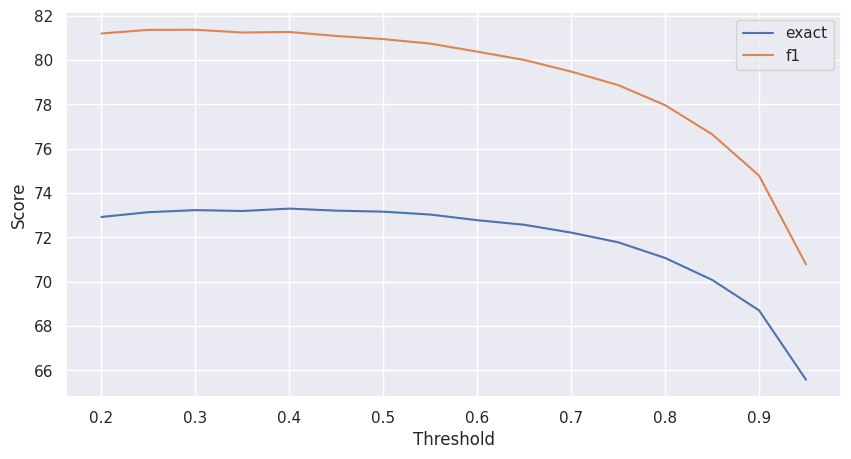

In [37]:
exacts = [m['exact'] for m in metrics]
f1s = [m['f1'] for m in metrics]
show_threshold_vs_score(thresholds, exacts, f1s)

In [38]:
predictions = get_predictions(model, test_dataset, batch_size=64)
start_logits, end_logits, answerable_logits = predictions['start_logits'], predictions['end_logits'], predictions['answerable_logits']

  0%|          | 0/186 [00:00<?, ?it/s]

In [46]:
compute_metrics(start_logits, end_logits, answerable_logits, test_dataset, test_dataset_for_reader, threshold=0.4, show_result=False)

  0%|          | 0/11873 [00:00<?, ?it/s]

{'exact': 78.80064010780762,
 'f1': 81.91452813057533,
 'total': 11873,
 'HasAns_exact': 74.2828214647317,
 'HasAns_f1': 80.52163221301399,
 'HasAns_total': 5926,
 'NoAns_exact': 83.30250546494031,
 'NoAns_f1': 83.30250546494031,
 'NoAns_total': 5947,
 'best_exact': 78.80064010780762,
 'best_exact_thresh': 0.0,
 'best_f1': 81.91452813057515,
 'best_f1_thresh': 0.0}